For this image retrieval task, I've divided the notebook into two parts: image-representation and search. For representation, I will be using a VGG for feature extraction in a Siamese Network. This is done for one set of two similar images and one set of two different images and a Triplet loss is calculated for the three images. This is used to train the model. In representation, I used FAISS(Facebook AI Similarity Search library) to index the features and perform a search. 

In [1]:
import numpy as np
import torch
import os
from torchvision.io import read_image
from torchvision.models import vgg16
import torch.nn as nn
import cv2
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt
from tqdm import tqdm
import random
from torch.utils.data import DataLoader, Dataset

Downloading the training data and labels. Dataset chosen for this task is the Stanford cars dataset. The dataset contains 16185 images divided equally into two train and test datasets that can be directly downloaded from the Stanford website along with labels. 

In [2]:
!wget http://ai.stanford.edu/~jkrause/car196/cars_train.tgz;
!wget http://ai.stanford.edu/~jkrause/cars/car_devkit.tgz;
!tar -xzvf /content/cars_train.tgz -C /content
!tar -xzvf /content/car_devkit.tgz -C /content
!pip install faiss-gpu

Streaming output truncated to the last 5000 lines.
cars_train/03158.jpg
cars_train/03159.jpg
cars_train/03160.jpg
cars_train/03161.jpg
cars_train/03162.jpg
cars_train/03163.jpg
cars_train/03164.jpg
cars_train/03165.jpg
cars_train/03166.jpg
cars_train/03167.jpg
cars_train/03168.jpg
cars_train/03169.jpg
cars_train/03170.jpg
cars_train/03171.jpg
cars_train/03172.jpg
cars_train/03173.jpg
cars_train/03174.jpg
cars_train/03175.jpg
cars_train/03176.jpg
cars_train/03177.jpg
cars_train/03178.jpg
cars_train/03179.jpg
cars_train/03180.jpg
cars_train/03181.jpg
cars_train/03182.jpg
cars_train/03183.jpg
cars_train/03184.jpg
cars_train/03185.jpg
cars_train/03186.jpg
cars_train/03187.jpg
cars_train/03188.jpg
cars_train/03189.jpg
cars_train/03190.jpg
cars_train/03191.jpg
cars_train/03192.jpg
cars_train/03193.jpg
cars_train/03194.jpg
cars_train/03195.jpg
cars_train/03196.jpg
cars_train/03197.jpg
cars_train/03198.jpg
cars_train/03199.jpg
cars_train/03200.jpg
cars_train/03201.jpg
cars_train/03202.jpg
cars

In [3]:
data = open('/content/devkit/train_perfect_preds.txt', 'r')
label = data.read()
# Organize the labels in a list for easy access
labels = label.split('\n')
labels.pop()
labels = [int(i) for i in labels]
data.close()

In [4]:
path = '/content/cars_train'
files = sorted(os.listdir('/content/cars_train'))
print(len(files))

8144


## **Image representation**
Next, we download the pre-trained VGG16 model and remove the dense layers and replace them with one dense layer of size 4096. This will give 4096 features, that we can use for computing the loss. 

In [5]:
def get_model():
  model = vgg16(pretrained=True)
  model.classifier = nn.Linear(model.classifier[0].in_features, 1024)
  model
  return model

In [6]:
def pre_process(image):
  """
  Function to pre-process images. Resize the images, normalize them 
  and convert them to tensors.

  Input :
  _______
  
  image : numpy array
  Input image, read using cv2

  Output :
  ________

  img : torch tensor
  Output image, converted to tensor to be fed to the NN

  """
  img = cv2.resize(image, (224, 224))
  img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
  # plt.imshow(img)
  img = img.reshape(3, 224, 224)
  
  img = img.astype('float32')/255.0

  return img

img = cv2.imread(os.path.join('/content/car_ims', files[36]))
# im = pre_process(img)

In [7]:
BATCH_SIZE = 32
DEVICE = 'cuda'
EPOCHS = 10

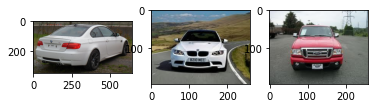

In [8]:
def select_images(labels, files):
  
        label = random.choice(labels)

        indices = [i for i in range(len(labels)) if labels[i] == label]
        im_indices = random.sample(indices, 2)  
        file_path = '/content/cars_train'
        ima = cv2.imread(os.path.join(file_path, files[im_indices[0]]))
        imp = cv2.imread(os.path.join(file_path, files[im_indices[1]]))
        ima = cv2.cvtColor(ima, cv2.COLOR_BGR2RGB)
        imp = cv2.cvtColor(imp, cv2.COLOR_BGR2RGB)
        im_a = pre_process(ima)
        im_p = pre_process(imp)
        neg_label = random.choice(labels)
        while neg_label == label:
          neg_label = random.choice(labels)
        neg_indices = [i for i in range(len(labels)) if labels[i] == neg_label]
        neg_idx = random.choice(neg_indices)
        imn = cv2.imread(os.path.join(file_path, files[neg_idx]))
        imn = cv2.cvtColor(imn, cv2.COLOR_BGR2RGB)
        im_n = pre_process(imn)
        
        plt.subplot(1, 3, 1), plt.imshow(ima)
        plt.subplot(1, 3, 2), plt.imshow(imp)
        plt.subplot(1, 3, 3), plt.imshow(imn)
        plt.show()

        im_a, im_p, im_n = im_a.astype(np.float32), im_p.astype(np.float32), im_n.astype(np.float32)
        im_a, im_p, im_n = torch.tensor(im_a), torch.tensor(im_p), torch.tensor(im_n)

        # return label, [im_a, im_p, im_n]
  
def form_batch(batch_size, labels, files):
  batch = []
  for b in range(batch_size):
    label, images = select_images(labels, files)
    batch.append(images)

# form_batch(BATCH_SIZE, labels, files)
select_images(labels, files)

In [9]:

# Class to organize data in batches and feed to DataLoader to prepare for
# the neural network.

class MakeData(Dataset):
    def __init__(self, labels, files, batch_num, split="train"):

        self.categories = max(labels)       # number of categories
        self.labels = labels
        self.files = files
        self.batch_num = batch_num
    
    def __getitem__(self, idx):
        # our positive class for the triplet
        idx = str(idx%self.categories + 1)
        
        label = random.choice(self.labels)

        indices = [i for i in range(len(self.labels)) if self.labels[i] == label]
        im_indices = random.sample(indices, 2)
        file_path = '/content/cars_train'

        # Identify two similar images - anchor and positive
        ima = cv2.imread(os.path.join(file_path, self.files[im_indices[0]]))
        imp = cv2.imread(os.path.join(file_path, self.files[im_indices[1]]))
        im_a = pre_process(ima)
        im_p = pre_process(imp)

        # Identify one negative image to complete the triplet
        neg_label = random.choice(self.labels)
        while neg_label == label:
          neg_label = random.choice(self.labels)
        neg_indices = [i for i in range(len(self.labels)) if self.labels[i] == neg_label]
        neg_idx = random.choice(neg_indices)
        imn = cv2.imread(os.path.join(file_path, self.files[neg_idx]))
        im_n = pre_process(imn)

        im_a, im_p, im_n = im_a.astype(np.float32), im_p.astype(np.float32), im_n.astype(np.float32)
        im_a, im_p, im_n = torch.tensor(im_a), torch.tensor(im_p), torch.tensor(im_n)
        
        return [im_a, im_p, im_n]
        
    def __len__(self):
        return self.categories*8

In [10]:
def TripletLoss(anchor, pos, neg):
  """
  Function to compute the triplet loss.

  Input :
  _______

  anchor : torch tensor
  Anchor image, the distances are calculated with this as reference.

  pos : torch tensor
  Positive image. This is a representation of the similar image.

  neg : torch tensor
  Negative image. This is a representation of the dissimilar iamge.

  Output : 
  ________

  loss : torch tensor
  This is computed triplet loss.
  """
  margin = 1.0
  pos_dist = (anchor - pos).pow(2).sum(1)
  neg_dist = (anchor - neg).pow(2).sum(1)
  loss = pos_dist - neg_dist + margin
  loss = torch.relu(loss).mean()
  return loss

In [11]:
train_data = MakeData(labels, files, BATCH_SIZE)

train_loader = DataLoader(dataset=train_data, batch_size=BATCH_SIZE)

In [12]:
# Load the model and send to GPU
model = get_model()
model.to(DEVICE)

/usr/local/lib/python3.8/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.8/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=VGG16_Weights.IMAGENET1K_V1`. You can also use `weights=VGG16_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
Downloading: "https://download.pytorch.org/models/vgg16-397923af.pth" to /root/.cache/torch/hub/checkpoints/vgg16-397923af.pth


  0%|          | 0.00/528M [00:00<?, ?B/s]

VGG(
  (features): Sequential(
    (0): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU(inplace=True)
    (2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (3): ReLU(inplace=True)
    (4): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (5): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (6): ReLU(inplace=True)
    (7): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (8): ReLU(inplace=True)
    (9): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (10): Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (11): ReLU(inplace=True)
    (12): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (13): ReLU(inplace=True)
    (14): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (15): ReLU(inplace=True)
    (16): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1

In [13]:
def train(model, epochs, batch_size, data_loader):
  """
  Function to train the model.

  Input :
  _______

  model : torch model
  The pre-trained model which needs to be further trained.

  epochs : int
  Number of training iterations to be performed.

  batch_size : int
  Number of triplets in every batch of training.

  data_loader : torch dataloader object
  The training data.

  Output :
  ________

  None
  
  """
  model.train()
  optimizer = torch.optim.SGD(model.parameters(), lr=0.001)

  for e in range(epochs):

    e_loss = 0
    # print(len(data_loader))
    for data in tqdm(data_loader):
      optimizer.zero_grad()
      a, p, n = data
      out_a = model(a.to(DEVICE))
      out_p = model(p.to(DEVICE))
      out_n = model(n.to(DEVICE))

      loss = TripletLoss(out_a, out_p, out_n)
      e_loss += loss
      loss.backward()
      optimizer.step()
    print(f"Training Loss: {e_loss.item()}")

train(model, EPOCHS, BATCH_SIZE, train_loader)

100%|██████████| 49/49 [01:12<00:00,  1.48s/it]


Training Loss: 50.50121307373047


100%|██████████| 49/49 [01:01<00:00,  1.25s/it]


Training Loss: 45.266639709472656


100%|██████████| 49/49 [00:59<00:00,  1.22s/it]


Training Loss: 45.35584259033203


100%|██████████| 49/49 [00:59<00:00,  1.22s/it]


Training Loss: 46.22342300415039


100%|██████████| 49/49 [01:00<00:00,  1.24s/it]


Training Loss: 46.72895050048828


100%|██████████| 49/49 [01:00<00:00,  1.23s/it]


Training Loss: 45.302886962890625


100%|██████████| 49/49 [01:03<00:00,  1.30s/it]


Training Loss: 45.66848373413086


100%|██████████| 49/49 [01:00<00:00,  1.23s/it]


Training Loss: 46.47734069824219


100%|██████████| 49/49 [01:00<00:00,  1.23s/it]


Training Loss: 45.578887939453125


100%|██████████| 49/49 [00:59<00:00,  1.22s/it]


Training Loss: 44.698699951171875


In [14]:
import faiss

# Indexing the computed features to perform search later

file_names = []
distance = []
faiss_index = faiss.IndexFlatL2(1024)

with torch.no_grad():
  for f in tqdm(files):
    image = cv2.imread(os.path.join(path, f))
    image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
    image = cv2.resize(image, (224, 224))
    image = image.reshape(3, 224, 224)
    image = image.astype('float32')/255.0
    image = torch.tensor(image).cuda()
    image = image.unsqueeze(0)

    preds = model(image)
    preds = np.array([preds[0].cpu().numpy()])

    faiss_index.add(preds)
    file_names.append(f)


100%|██████████| 8144/8144 [02:02<00:00, 66.22it/s]


# **Search**
This is the search part of the retrieval process. I continue to use the faiss library for the process. It returns the image title, corresponding image can be read using cv2.

In [15]:
def search_image(image):
  """
  Function to search the closest match to the test image in the database.

  Input :
  _______

  image : ndarray
  Input image that needs to be pre-processed and run through NN.

  Output :
  ________
  file_name : str
  Name of the most similar file.
  
  """
  with torch.no_grad():
    # image = cv2.imread(os.path.join(path, files[0]))
    image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
    image = cv2.resize(image, (224, 224))
    image = image.reshape(3, 224, 224)
    image = image.astype('float32')/255.0
    image = torch.tensor(image).cuda()
    image = image.unsqueeze(0)

    pred = model(image)
    pred = np.array([pred[0].cpu().numpy()])

    _, I = faiss_index.search(pred, 5)
    # print("Retreived image: {}".format(file_names[I[0][0]]))
    return file_names[I[0][0]]



Download the test data

In [16]:
!wget http://ai.stanford.edu/~jkrause/car196/cars_test.tgz
!tar -xzvf /content/cars_test.tgz -C /content

Streaming output truncated to the last 5000 lines.
cars_test/03042.jpg
cars_test/03043.jpg
cars_test/03044.jpg
cars_test/03045.jpg
cars_test/03046.jpg
cars_test/03047.jpg
cars_test/03048.jpg
cars_test/03049.jpg
cars_test/03050.jpg
cars_test/03051.jpg
cars_test/03052.jpg
cars_test/03053.jpg
cars_test/03054.jpg
cars_test/03055.jpg
cars_test/03056.jpg
cars_test/03057.jpg
cars_test/03058.jpg
cars_test/03059.jpg
cars_test/03060.jpg
cars_test/03061.jpg
cars_test/03062.jpg
cars_test/03063.jpg
cars_test/03064.jpg
cars_test/03065.jpg
cars_test/03066.jpg
cars_test/03067.jpg
cars_test/03068.jpg
cars_test/03069.jpg
cars_test/03070.jpg
cars_test/03071.jpg
cars_test/03072.jpg
cars_test/03073.jpg
cars_test/03074.jpg
cars_test/03075.jpg
cars_test/03076.jpg
cars_test/03077.jpg
cars_test/03078.jpg
cars_test/03079.jpg
cars_test/03080.jpg
cars_test/03081.jpg
cars_test/03082.jpg
cars_test/03083.jpg
cars_test/03084.jpg
cars_test/03085.jpg
cars_test/03086.jpg
cars_test/03087.jpg
cars_test/03088.jpg
cars_test

Downloading and organzing the labels for test images

In [17]:
import scipy.io

!wget http://ai.stanford.edu/~jkrause/car196/cars_test_annos_withlabels.mat
mat = scipy.io.loadmat('/content/cars_test_annos_withlabels.mat')


--2023-02-03 15:03:22--  http://ai.stanford.edu/~jkrause/car196/cars_test_annos_withlabels.mat
Resolving ai.stanford.edu (ai.stanford.edu)... 171.64.68.10
Connecting to ai.stanford.edu (ai.stanford.edu)|171.64.68.10|:80... connected.
HTTP request sent, awaiting response... 200 OK
Length: 185758 (181K) [text/plain]
Saving to: ‘cars_test_annos_withlabels.mat’

cars_test_annos_wit 100%[===================>] 181.40K   530KB/s    in 0.3s    

2023-02-03 15:03:23 (530 KB/s) - ‘cars_test_annos_withlabels.mat’ saved [185758/185758]



In [18]:
test_labels = []
test_names = []
test_files = sorted(os.listdir('/content/cars_test'))
for i in range(len(test_files)):
  test_labels.append(int(mat['annotations'][0][i][4]))

# print(test_labels)
# print(test_files)

Get the features of the test images and find the closest match in the training data.

In [19]:
test_path = '/content/cars_test'
pred_label = []
pred_images = []
for f in tqdm(test_files):

  test_image = cv2.imread(os.path.join(test_path, f))
  idx = search_image(test_image)
  pred_images.append(idx)
  pred_label.append(labels[files.index(idx)])

100%|██████████| 8041/8041 [04:27<00:00, 30.11it/s]


In [20]:
print(pred_label)
print(test_labels)
print(pred_images)

[181, 139, 189, 81, 183, 148, 96, 154, 23, 66, 59, 159, 8, 72, 81, 22, 20, 11, 179, 16, 98, 7, 105, 34, 37, 117, 9, 21, 86, 165, 92, 94, 187, 12, 149, 94, 10, 34, 90, 81, 145, 104, 122, 122, 147, 62, 175, 53, 28, 66, 62, 9, 74, 31, 133, 79, 142, 98, 103, 179, 83, 58, 18, 43, 172, 155, 182, 143, 105, 22, 87, 30, 54, 11, 85, 73, 39, 9, 172, 140, 82, 5, 112, 104, 119, 135, 102, 146, 9, 61, 105, 9, 90, 137, 66, 48, 33, 147, 53, 8, 18, 109, 29, 47, 37, 86, 81, 42, 110, 142, 28, 58, 194, 130, 26, 124, 139, 148, 187, 61, 64, 85, 7, 46, 58, 50, 54, 10, 33, 12, 68, 40, 146, 138, 37, 85, 5, 32, 78, 53, 188, 62, 84, 63, 77, 62, 28, 103, 172, 132, 138, 9, 170, 56, 42, 2, 83, 93, 121, 157, 98, 81, 173, 103, 110, 143, 139, 86, 115, 172, 79, 84, 147, 8, 31, 176, 98, 111, 128, 60, 130, 172, 176, 43, 155, 182, 113, 114, 63, 174, 148, 35, 72, 156, 64, 25, 172, 92, 147, 169, 2, 185, 60, 186, 26, 135, 1, 161, 101, 141, 91, 187, 105, 170, 31, 30, 112, 41, 69, 87, 95, 73, 176, 173, 44, 137, 133, 138, 150, 2

Computing the accuracy of the predictions

In [21]:
correct_labels = [int(pred_label[i] == test_labels[i]) for i in range(len(test_labels))]
accuracy = sum(correct_labels)/len(correct_labels)*100
print(f'Prediction accuracy: {accuracy}')

Prediction accuracy: 2.0395473199850764


In [22]:
train_im = cv2.imread(os.path.join(path, pred_images[56]))
plt.imshow(train_im)

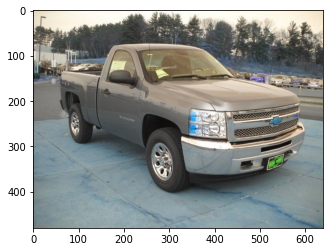

In [23]:
test_im = cv2.imread(os.path.join(test_path, test_files[56]))
plt.imshow(test_im)